In [19]:
!pip install -r requirements.txt

In [1]:
import os, random, datetime
from sklearn.cluster import KMeans
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
from functions.functions import map_to_alphabet, assign_time_label, find_birthday, top_ordered_items, get_discount, extract_last_4_digits
from functions.functions import initialize_chain, birthday_message, special_day_offer, cluster_based_offer, churn_message
from functions.functions import top_item_finder, churn_verifier, generate_birthdays, convert_to_orderwise

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Prepping the Dataset

### Reading Dataframe

In [4]:
ungrouped = pd.read_csv("data/Marketing_data.csv", index_col=0)
ungrouped['Last 4 Card Digits'] = ungrouped['Last 4 Card Digits'].astype(str).str.split('.').str[0].str.zfill(4)
ungrouped = ungrouped[ungrouped['Voided?'] != 'True']
ungrouped.head(5)

,Menu Item,Modifiers,Price,Qty,Discount,Net,Tax,Total,Voided?,Reason,Refund Qty,Refund,Last 4 Card Digits,Order Date,Tip,Gratuity
0,Margarita Rock Flight,Salt,$24.00,1.0,$0.00,$24.00,$2.250,$26.25,False,NaN,0,$0.00,3108,2023-12-08 18:46:00,$6.86,$45.71
1,Margarita Rock Flight,Salt,$24.00,1.0,$0.00,$24.00,$2.250,$26.25,False,NaN,0,$0.00,3108,2023-12-08 18:46:00,$6.86,$45.71
2,Mojito Flight,NaN,$24.00,1.0,$0.00,$24.00,$2.250,$26.25,False,NaN,0,$0.00,3108,2023-12-08 18:46:00,$6.86,$45.71
3,Mojito Flight,NaN,$24.00,1.0,$0.00,$24.00,$2.250,$26.25,False,NaN,0,$0.00,3108,2023-12-08 18:46:00,$6.86,$45.71
4,Mojito Flight,NaN,$24.00,1.0,$0.00,$24.00,$2.250,$26.25,False,NaN,0,$0.00,3108,2023-12-08 18:46:00,$6.86,$45.71


### Generating Random Birthdays

In [5]:
ungrouped['Birthday'] = generate_birthdays(ungrouped)

### Generating Random Names

In [6]:
ungrouped['Name'] = ungrouped['Last 4 Card Digits'].apply(map_to_alphabet)

### Orderwise Data

In [7]:
grouped = convert_to_orderwise(ungrouped)
grouped.head(5)

,Last 4 Card Digits,Order Date,Menu Item,Qty,Total,Tip
0,0000,2024-02-03 14:17:00,"Frozen Margarita Flight, Frozen Margarita Flig...",5.0,91.89,11.00
1,0004,2024-01-14 17:45:00,"Martini Flight, Chicken Wing Flight",2.0,51.36,35.00
2,0010,2023-11-20 18:28:00,"Skewer Flight, Jack Daniels",2.0,37.12,13.83
3,0010,2023-12-07 19:35:00,"Margarita Rock Flight, Beer Flight, Hummus, Mi...",36.0,692.74,0.00
4,0010,2024-02-24 19:26:00,"Fry Flight, Ahi Tuna Taco Flight, Frozen Marga...",3.0,64.42,22.71


# Task-1 : AI-Driven Marketing

## A) Basic Automation for Engagement

### Point - 1 : Automated Functions

In [8]:
def top_item_finder():

  # Item Data to get the price and categoy of the Items
  item_data = pd.read_excel('data/Campbell Menu Data - 2.xlsx', index_col=0)

  # Rename the column 'itemName' to 'Menu Item'
  item_data.rename(columns={"itemName": "Menu Item"}, inplace=True)
  ungrouped_data = pd.read_csv('data/Marketing_data.csv', index_col=0)
  category_dict = item_data.groupby('Category')['Menu Item'].apply(list).to_dict()
  itemp = item_data.groupby('Menu Item')['itemPrice'].apply(list).to_dict()

  for category, items in category_dict.items():
      ungrouped_data.loc[ungrouped_data['Menu Item'].isin(items), 'Category'] = category

  for item, price in itemp.items():
    ungrouped_data.loc[ungrouped_data['Menu Item'] == item, 'ItemPrice'] = price[0]

  top_items = []
  for cat in ['Entrées','Flights Cocktails','Brunch Food','Desserts']:
    top_items.append(list(ungrouped_data[ungrouped_data.Category == cat]['Menu Item'].value_counts().to_dict().keys())[0])

  top_items = list(set(top_items))
  prices = []
  for i in top_items:
    prices.append(ungrouped_data[ungrouped_data['Menu Item'] == i].ItemPrice.values[0])

  return top_items, prices

### Point - 2 : Clustering

In [9]:
# Remove the specified rows & Reindex
rows_to_remove = [468, 2212]
grouped = grouped.drop(index=rows_to_remove)

grouped = grouped.reset_index(drop=True)

#### 1. Clustring based on Spending Patterns

##### Feature Engineering

In [10]:
def assign_label(avg_spending):
    """
    Assigns a label based on the average spending compared to percentiles.
    """
    if avg_spending < percentiles * 0.5:
        return 'Economy'
    elif avg_spending > percentiles * 1.5:
        return 'Premium'
    else:
        return 'Standard'

In [11]:
customer_avg_spending = grouped.groupby('Last 4 Card Digits')['Total'].mean().reset_index()

# Calculate percentiles & Categorize
percentiles = customer_avg_spending.Total.mean()
customer_avg_spending['Orderer Type'] = customer_avg_spending['Total'].apply(assign_label)
data = customer_avg_spending

# Merge cluster labels with original data
cluster = grouped.merge(customer_avg_spending[['Last 4 Card Digits', 'Orderer Type']], on='Last 4 Card Digits', how='left')
cluster[['Last 4 Card Digits', 'Order Date', 'Menu Item', 'Qty', 'Total', 'Tip', 'Orderer Type']].head(5)

,Last 4 Card Digits,Order Date,Menu Item,Qty,Total,Tip,Orderer Type
0,0000,2024-02-03 14:17:00,"Frozen Margarita Flight, Frozen Margarita Flig...",5.0,91.89,11.00,Standard
1,0004,2024-01-14 17:45:00,"Martini Flight, Chicken Wing Flight",2.0,51.36,35.00,Standard
2,0010,2023-11-20 18:28:00,"Skewer Flight, Jack Daniels",2.0,37.12,13.83,Premium
3,0010,2023-12-07 19:35:00,"Margarita Rock Flight, Beer Flight, Hummus, Mi...",36.0,692.74,0.00,Premium
4,0010,2024-02-24 19:26:00,"Fry Flight, Ahi Tuna Taco Flight, Frozen Marga...",3.0,64.42,22.71,Premium


##### Visualizing cluster

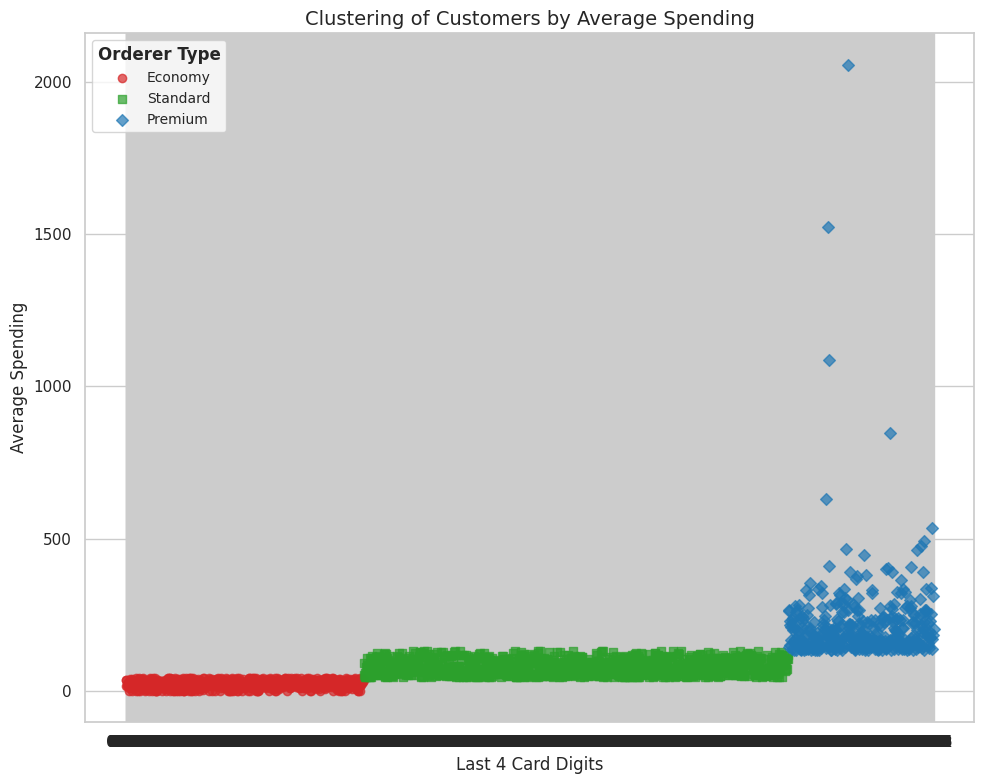

In [12]:
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(10, 8))

colors = {'Economy': 'tab:red', 'Standard': 'tab:green', 'Premium': 'tab:blue'}
markers = {'Economy': 'o', 'Standard': 's', 'Premium': 'D'}

for order_type, color in colors.items():
    cluster_data = data[data['Orderer Type'] == order_type]
    ax.scatter(cluster_data['Last 4 Card Digits'], cluster_data['Total'], c=color, label=order_type, marker=markers[order_type], alpha=0.7)

ax.set_xlabel('Last 4 Card Digits', fontsize=12)
ax.set_ylabel('Average Spending', fontsize=12)
ax.set_title('Clustering of Customers by Average Spending', fontsize=14)

legend = ax.legend(title='Orderer Type', fontsize=10, title_fontsize=12)
legend.get_title().set_fontweight('bold')

plt.tight_layout()
plt.show()

#### 2. Clustring based on Spending Patterns

##### Feature Engineering

In [13]:
cluster['Order Date'] = pd.to_datetime(cluster['Order Date'])
cluster['Order Hour'] = cluster['Order Date'].dt.hour
cluster['Time of Day'] = cluster['Order Hour'].apply(assign_time_label)
cluster.head(5)

,Last 4 Card Digits,Order Date,Menu Item,Qty,Total,Tip,Orderer Type,Order Hour,Time of Day
0,0000,2024-02-03 14:17:00,"Frozen Margarita Flight, Frozen Margarita Flig...",5.0,91.89,11.00,Standard,14,Evening
1,0004,2024-01-14 17:45:00,"Martini Flight, Chicken Wing Flight",2.0,51.36,35.00,Standard,17,Evening
2,0010,2023-11-20 18:28:00,"Skewer Flight, Jack Daniels",2.0,37.12,13.83,Premium,18,Night
3,0010,2023-12-07 19:35:00,"Margarita Rock Flight, Beer Flight, Hummus, Mi...",36.0,692.74,0.00,Premium,19,Night
4,0010,2024-02-24 19:26:00,"Fry Flight, Ahi Tuna Taco Flight, Frozen Marga...",3.0,64.42,22.71,Premium,19,Night


## B) Personalized Marketing Campaigns



### Point 1 & 2


##### General Level (Special Day Offer)

In [14]:
# User Choice
format = "email"
occasion = "Thanks Giving Day" # (New Years Eve, Valentine, USA Independence Day, Halloween, Christmas)
name = "shaffay"
discount_percent = 10

# Based On Data
top_items, _  = top_item_finder()
initial_price = int(sum(_))
after_discount = initial_price - (initial_price * (discount_percent/100))

message = special_day_offer(format, name, occasion, top_items, initial_price, discount_percent, after_discount)
print(message)

Subject: Special Thanks Giving Day Offer for Our Valued Customer!

Dear Shaffay,

We at AIO are thrilled to celebrate Thanks Giving Day with you! To show our appreciation, we are offering a special discount on our most loved menu items. 

As a token of our gratitude, we are offering a 10% discount on the following bestselling items:
- Cast Iron Hash Flight
- Beignet Flight
- Margarita Rock Flight
- Fettuccine Alfredo

The total price of these items is $71, but with the 10% discount, the price comes down to $63.9.

We hope you take advantage of this special offer and enjoy these delicious dishes with your loved ones on this special day.

Regards,
AIO Team


##### Customer Level (Birthday Offer)

In [19]:
# User Choice
format = "small message"
birthday = "1990-10-08"
discount_percent = 10

# Based On Data
birthday_data = find_birthday(int(birthday.split("-")[0]), int(birthday.split("-")[1]), int(birthday.split("-")[2]), ungrouped).iloc[0]
last_4_digits = birthday_data["Last 4 Card Digits"]

name = birthday_data["Name"]
top_items, _ = top_ordered_items(last_4_digits, ungrouped)
initial_price = int(sum(_))
after_discount = initial_price - (initial_price * (discount_percent/100))

In [27]:
message = birthday_message(format, name, birthday, top_items, initial_price, discount_percent, after_discount)
print(message)

"Happy Birthday FECH! 🎉 As a special birthday treat, we're offering you a 10% discount on your favorite bundle items - Martini Flight and Margarita Rock Flight. You can now enjoy these items for just $43.20. Come celebrate your special day with us at AIO! 🎂🥳"


##### Group Level (Cluster Based Offer)
- Group based on Spending Pattern (Premium, Standard, Economy)
- Group based on Customer activity times (Morning, Evening, Mid-day)
- Group based on Food Preference (Food category, Most Selling Product)

In [20]:
# User Choice
format = "email"
name = "DBAI"

# Based On Data
fp, _  = top_item_finder()
initial_price = int(sum(_))

code = extract_last_4_digits(ungrouped, name)

### Spending patteren will be used to specify discounts
sp = cluster.loc[cluster['Last 4 Card Digits'] == code, 'Orderer Type'].values[0]
discount_percent = get_discount(sp)
after_discount = initial_price - (initial_price * (discount_percent/100))

### Activity times ill be used to set email time
at = cluster.loc[cluster['Last 4 Card Digits'] == code, 'Time of Day'].values[0]
print(f"Customer {name} belongs to {sp} orderer type and {at} time.")

Customer DBAI belongs to Premium orderer type and Night time.


In [21]:
message = cluster_based_offer(format, name, fp, initial_price, discount_percent, after_discount)
print(message)

Subject: Special Offer Just for You, DBAI!

Dear DBAI,

We at AIO are thrilled to offer you a special discount on your most liked items. As a valued customer, we want to show our appreciation by giving you a 5% discount on the following items:
- Cast Iron Hash Flight
- Beignet Flight
- Margarita Rock Flight
- Fettuccine Alfredo

The total price of these items comes to $71, but with the 5% discount, you will only pay $67.45.

We hope you take advantage of this special offer and visit us soon to enjoy your favorite dishes at a discounted price.

Regards,
AIO Team


## C) Customer Segmentation and Churn Prediction


#### Mapped Data

In [23]:
ungrouped_data = pd.read_csv('data/Churn.csv', index_col=0)
ungrouped_data.head(5)

,Menu Item,Qty,Total,Tip,Date_x,Time
Last 4 Card Digits,,,,,,
8834,"Margarita Rock Flight, Elysian Space Dust, Fli...",11.0,162.62,2.00,2023-11-05,12:49:00
5709,"HH Mimosa Flight, HH Mimosa Flight, Salad Flig...",4.0,72.08,20.43,2023-11-05,13:58:00
7260,"Titos, HH Mimosa Flight",1.5,21.33,5.00,2023-11-05,11:27:00
7940,"Mojito Flight, Slider Flight",2.0,48.07,9.61,2023-11-05,18:08:00
8465,Jack Daniels,1.0,13.12,2.62,2023-11-05,17:56:00


### Global Item Finder



In [24]:
top_item_finder()

(['Cast Iron Hash Flight',
  'Beignet Flight',
  'Margarita Rock Flight',
  'Fettuccine Alfredo'],
 [17.95, 10.95, 24.0, 18.95])

### Individual Item Finder


In [ ]:
churn_verifier(ungrouped_data, int("7260"))

### Email

In [44]:
# User Choice
format = "small message"
code = "7260"
name = ungrouped.loc[ungrouped['Last 4 Card Digits'] == name, 'Name'][0]
discount_percent = 10

# Based On Data
top_items, prices = churn_verifier(ungrouped_data, int(code))
top_items = top_items
initial_price = sum(prices)
after_discount = initial_price - (initial_price * (discount_percent/100))

message = churn_message(format, name, top_items, initial_price, discount_percent, after_discount)
print(message)

Dear HCGA, 
We just wanted to take a moment to express our gratitude for being a valued customer at AIO. Your support means the world to us. As a token of our appreciation, we are delighted to offer you a personalized 10% discount on your favorite items, HH Mimosa Flight and Titos, bringing the price down to just $24.3. We hope to see you again soon!
